<div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 20px;">
    <img src="https://www.goes-r.gov/imagesContent/multimedia/goesSeriesLogos/goesRLogos/color/small.jpg" alt="EarthScope Consortium Logo" style="width: 150px; margin-top: 10px;">
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0;">
        <img src="https://www.sci.utah.edu/images/news/2023/sci-30-multi.jpg" alt="Scientific Computing and Imaging Institute Logo" width="100"/>
    </div>
</div>

<h1 style="text-align: center; font-size: 24px; margin-top: 0;">NSF National Data Platform (NDP)</h1>
<h3 style="text-align: center; font-size: 18px; margin-top: 10px;">NASA-GOES R Satellite Data RADC product Visualization</h3>

<div style="margin: 20px 0;">
    <p>NOAA's latest generation of geostationary weather satellites
The Geostationary Operational Environmental Satellite (GOES) – R Series is the nation’s most advanced fleet of geostationary weather satellites. The GOES-R Series significantly improves the detection and observation of environmental phenomena that directly affect public safety, protection of property and our nation’s economic health and prosperity.
The satellites provide advanced imaging with increased spatial resolution and faster coverage for more accurate forecasts, real-time mapping of lightning activity, and improved monitoring of solar activity and space weather.
The GOES-R Series is a four-satellite program (GOES-R/S/T/U) that will extend the availability of the operational GOES satellite system through 2036.</p>
</div>

<center>
    <div style="text-align: right; padding: 5px;">
        <p style="text-align: right;"><strong>Contact:</strong> Scientific and Computing Imaging Institute, University of Utah (<a href="mailto:saleem.alharir@utah.edu">saleem.alharir@utah.edu</a>)</p>
    </div>
</center>

<div style="display: flex; align-items: center; justify-content: flex-start; margin-top: 20px; border-top: 1px solid #ccc; padding-top: 20px;">
    <img src="https://new.nsf.gov/themes/custom/nsf_theme/components/images/logo/logo-desktop.svg" alt="NSF Logo" style="width: 120px; margin-right: 10px;">
    <p style="font-size: 12px;">The National Data Platform was funded by NSF 2333609 under CI, CISE Research Resources programs. Any opinions, findings, conclusions, or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the funders.</p>
</div>


In [ ]:
!pip install h5netcdf h5py xarray
!pip install tqdm pymongo s3fs xarray cftime

In [1]:
from datetime import datetime, timedelta
from kafka import KafkaConsumer
import os
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm  # Import the tqdm module
from datetime import datetime, timezone, timedelta
import time
import requests
from pymongo import MongoClient
import copy
import csv
import s3fs
import xarray as xr
import io
import multiprocessing
import cftime
import sys
import re
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from botocore.config import Config
from botocore.handlers import disable_signing
s3 = boto3.client(
    's3',
    aws_access_key_id='',
    aws_secret_access_key='',
    config=Config(signature_version='UNSIGNED')
)
# Disable signing for paginated requests
s3.meta.events.register('choose-signer.s3.*', disable_signing)
session = boto3.Session(aws_access_key_id='', 
                        aws_secret_access_key='')

In [2]:
CKAN_URL = 'http://ckan.geosciframe.org:5000/catalog'

def download_file(url, local_filename):
    response = requests.get(url, stream=True)
    with open(local_filename, 'wb') as output_file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                output_file.write(chunk)
def download_ckan_dataset_files(dataset_name):
    """Get dataset details from CKAN and download files."""
    response = requests.get(f"{CKAN_URL}/api/3/action/package_show", params={"id": dataset_name})
    dataset_details = response.json()
    downloaded_files = []  # Create an empty list to store downloaded file names
    
    if dataset_details['success']:
        resources = dataset_details['result']['resources']
        for resource in resources:
            if resource['format'].lower() in ['netcdf', 'nc']:
                file_url = resource['url']
                print(f"File URL: {file_url}")
                local_filename = file_url.split('/')[-1]
                print(f"Local filename: {local_filename}")
                downloaded_files.append(local_filename)  # Append the file name to the list
                
                print(f"Downloading {local_filename}...")
                download_file(file_url, local_filename)
                
    else:
        print("Failed to get dataset details.")
    
    return downloaded_files  # Return the list of downloaded file names

# Example usage
dataset_name = "abi-l1b-radc_2020_122_00_or_abi-l1b-radc-m6c01_g17_s20201220001177_e20201220003550_c20201220003598"
downloaded_files = download_ckan_dataset_files(dataset_name)
print("Downloaded files:", downloaded_files)

File URL: https://noaa-goes17.s3.amazonaws.com/ABI-L1b-RadC/2020/122/00/OR_ABI-L1b-RadC-M6C01_G17_s20201220001177_e20201220003550_c20201220003598.nc
Local filename: OR_ABI-L1b-RadC-M6C01_G17_s20201220001177_e20201220003550_c20201220003598.nc
Downloaded files: ['OR_ABI-L1b-RadC-M6C01_G17_s20201220001177_e20201220003550_c20201220003598.nc']


In [3]:
print(downloaded_files)

['OR_ABI-L1b-RadC-M6C01_G17_s20201220001177_e20201220003550_c20201220003598.nc']


### Visualize the data for RADC only for the file retrieved from CKAN

<hr>

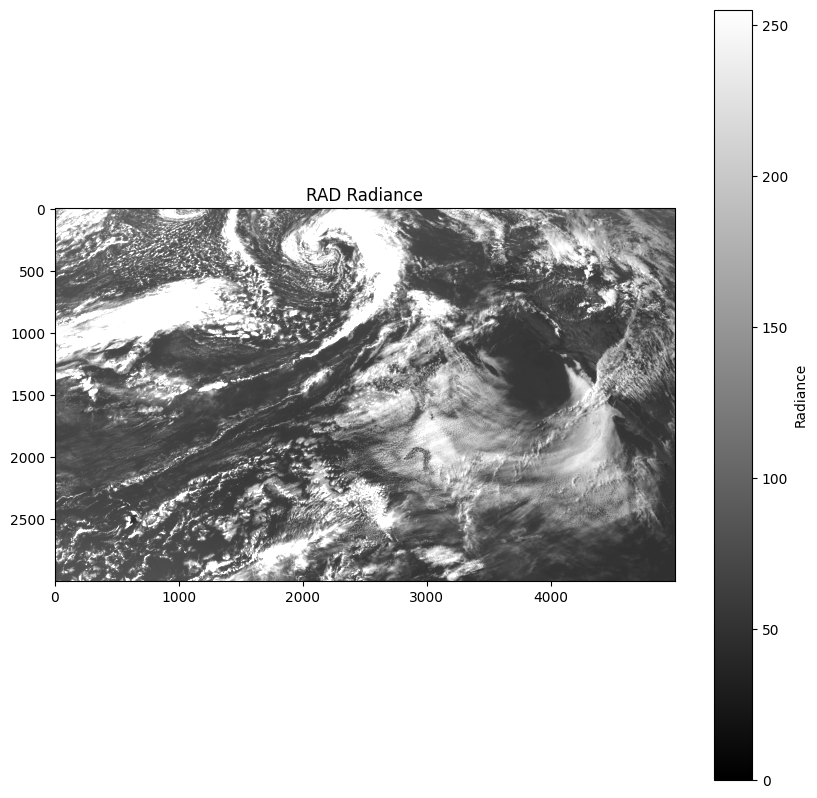

In [4]:
import json
try:
    ds_radc = xr.open_dataset(downloaded_files[0])
    radiance = np.array(ds_radc['Rad'])
    # Plot radiance
    plt.figure(figsize=(10, 10))
    plt.imshow(radiance, cmap='gray', vmin=0, vmax=255)
    plt.colorbar(label='Radiance')
    plt.title('RAD Radiance')
    plt.show()
except Exception as e:
    print(f"Error plotting the file: {str(e)}")